## Neural Processes

This notebook demonstrates the implementation of the Neural Processes. The model is trained to predict the distribution of the target function given a few examples of the function. In this notebook we will attempt to reconstruct an entire image given a few pixels of the image. we will be using the MNIST dataset for this task. The few pixels of the image are the context points and the entire image is the target function.

$$Model(\{x_i, y_i\}_{c=1}^n, \{x_j\}_{t=1}^m) \rightarrow \{y_j\}_{j=1}^m$$ 

$\{x_i, y_i\}_{c=1}^n$ are the context points where $x_i$ are the pixel coordinates and $y_i$ are the pixel intensity values.

$\{x_j\}_{t=1}^m$ are the target pixel coordinates where we want to predict the pixel intensity values $y_j$.

So for our case, the pixel locations $x = (x_1, x_2)$ and the pixel intensity values $y = Img(x1, x2)$ or just $I$ denoting intensity for simplicity.

$$Model(\{(x_1, x_2, I)\}_{c=1}^n, \{(x_1, x_2)\}_{t=1}^m) \rightarrow \{I\}_{j=1}^m$$

The model is composed of two neural networks: the encoder and the decoder. The encoder takes pixel coordinates and pixel intensitiy value of that coordinate as input and encodes them into a fixed-size representation. The decoder takes the representation and the pixel coordinates and predicts the pixel intensity value of the given coordinate.
 
### Training the model

During  model training we will sample a random number of pixel locations from the image and use them as context points. The model is trained to predict the pixel intensity value of the  sampled pixel locations. The model is trained using Mean Squared Error loss.

In [354]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader, Dataset

from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

from torchsummary import summary

In [ ]:
class Neural_Procss_Model(nn.Module):
    """
    Neural Process Model has two parts: encoder and decoder

    Encoder takes in the context pairs (X1_c, X2_c, PixelIntensity) and encode them into a latent representation

    Decoder takes in the latent representation and the target pairs (X1_t, X2_t) and output the predicted target pairs
    """
    def __init__(self):
        super(Neural_Procss_Model, self).__init__()

        # Encoder takes in the context pairs (X1c,X2c,PixelIntensity) and encode them into a latent representation
        self.encoder = nn.Sequential(
            nn.Linear(3,64),
            nn.ReLU(),
            nn.Linear(64,128),
            nn.ReLU(),
            nn.Linear(128,256),
        )

        # Decoder takes in the latent representation and the target pairs and output the predicted target pairs
        self.decoder = nn.Sequential(
            nn.Linear(256+2,128),
            nn.ReLU(),
            nn.Linear(128,64),
            nn.ReLU(),
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32,1)
        )

    def forward(self, context_pairs, target_pairs):
        """
        Forward pass of the Neural Process Model. 
        
        It takes in the context cordinate pairs (X1_c, X2_c, PixelIntensity) and target cordinate pairs (X1_t, X2_t, PixelIntensity) and output the predicted target pixel intensity for the target cordinate pairs

        Parameters:
        context_pairs: torch.Tensor of shape (batch_size, num_context_pairs, 3)
        target_pairs: torch.Tensor of shape (batch_size, num_target_pairs, 2)

        Returns:
        predicted_target_Pixel Intensity: torch.Tensor of shape (batch_size, num_target_pairs, 1)
        """
        
        # Encode the context pairs into a latent representation
        latent_representation = self.encoder(context_pairs)

        # Average the latent representation
        latent_representation = torch.mean(latent_representation,dim=1)

        # Repeat the latent representation for each target pair
        latent_representation = latent_representation.unsqueeze(1).repeat(1,target_pairs.size(1),1)

        # Concatenate the latent representation with the target pixel locations
        target_pixel_locations = target_pairs[:,:,:2]
        target = torch.cat([latent_representation,target_pixel_locations],dim=-1)

        # Decode the target pairs to obtain the predicted target pixel intensity
        predicted_target_pixel_intensity = self.decoder(target)

        return predicted_target_pixel_intensity
    

    def train(self, train_dataloader, num_epochs=100, optim = torch.optim.Adam, lr=3e-4, criterion = nn.MSELoss(),verbose=True,device='cuda'):
        """
        Train the Neural Process Model

        Parameters:
        train_dataloader: DataLoader object for the training data
        num_epochs: int, number of epochs to train the model
        optimer: str, optimer to use for training the model
        lr: float, learning rate for the optimer
        criterion: loss function to use for training the model
        """

        # Move the model to the device
        self.to(device)

        # Initialize the optimizer
        optimizer = optim(self.parameters(), lr=lr)

        for epoch in range(num_epochs):
            for i, (context_pairs, target_pairs) in enumerate(train_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs = target_pairs.to(device)

                # print(context_pairs.shape, target_pairs.shape)

                # Zero the gradients
                optimizer.zero_grad()

                # Forward pass
                predicted_target_pixel_intensity = self(context_pairs, target_pairs)

                # Calculate the loss
                loss = criterion(predicted_target_pixel_intensity.reshape(-1,1), target_pairs[:,:,2].reshape(-1,1))

                # Backward pass
                loss.backward()

                # Update the weights
                optimizer.step()

            if verbose:
                print("Epoch: {}/{} Loss: {:.5f}".format(epoch+1,num_epochs,loss.item()))



    def test(self, test_dataloader, criterion = nn.MSELoss(),device='cuda'):
        """
        Test the Neural Process Model

        Parameters:
        test_dataloader: DataLoader object for the test data
        """
    
        # Move the model to the device
        self.to(device)

        # Initialize the loss
        test_loss = 0

        with torch.no_grad():
            for i, (context_pairs, target_pairs) in enumerate(test_dataloader):
                context_pairs = context_pairs.to(device)
                target_pairs = target_pairs.to(device)

                # Forward pass
                predicted_target_pixel_intensity = self(context_pairs, target_pairs)

                # Calculate the loss
                loss = criterion(predicted_target_pixel_intensity.reshape(-1,1), target_pairs[:,:,2].reshape(-1,1))

                test_loss += loss.item()

        print(f'Test Loss: {test_loss/len(test_dataloader)}')

        

### Generating Trainset for the Problem

In [347]:
train_data = MNIST(root='./data', train=True, download=True, transform=ToTensor())

no_context_points = 200
All_corrdinates = np.array([(i,j) for i in range(28) for j in range(28)])

train_set = []
for i in range(len(train_data)):
    image, _ = train_data[i]
    image = image.squeeze().numpy()

    train_idx = np.random.choice(range(len(All_corrdinates)), no_context_points, replace=False)

    context_points = All_corrdinates[train_idx]
    context_pixels = image[context_points[:,0], context_points[:,1]]

    context_set = np.concatenate([context_points, context_pixels.reshape(-1,1)], axis=-1).astype(np.float32)

    target_set = context_set.copy()

    train_set.append((context_set, target_set))


train_dataloader = DataLoader(train_set, batch_size=32, shuffle=True)

for context_pairs, target_pairs in train_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

torch.Size([32, 200, 3]) torch.Size([32, 200, 3])


### Generating testset for the problem

In [348]:
test_data = MNIST(root='./data', train=False, download=True, transform= ToTensor())

no_context_points = 200
test_set = []
for i in range(len(test_data)):
    image, _ = test_data[i]
    image = image.squeeze().numpy()

    test_idx = np.random.choice(range(len(All_corrdinates)), no_context_points, replace=False)

    context_points = All_corrdinates[test_idx]
    context_pixels = image[context_points[:,0], context_points[:,1]]

    context_set = np.concatenate([context_points, context_pixels.reshape(-1,1)], axis=-1).astype(np.float32)

    target_points = np.array([(i,j) for i in range(28) for j in range(28)])
    target_pixels = image[target_points[:,0], target_points[:,1]]

    target_set = np.concatenate([target_points, target_pixels.reshape(-1,1)], axis=-1).astype(np.float32)

    test_set.append((context_set, target_set))

test_dataloader = DataLoader(test_set, batch_size=32, shuffle=True)

for context_pairs, target_pairs in test_dataloader:
    print(context_pairs.shape, target_pairs.shape)
    break

torch.Size([32, 200, 3]) torch.Size([32, 784, 3])


### Training the model

In [349]:
model = Neural_Procss_Model()

model.to('cuda')

model.train(train_dataloader, num_epochs=30)

Epoch: 1/30 Loss: 0.06666
Epoch: 2/30 Loss: 0.06497
Epoch: 3/30 Loss: 0.06212
Epoch: 4/30 Loss: 0.06163
Epoch: 5/30 Loss: 0.05931
Epoch: 6/30 Loss: 0.05229
Epoch: 7/30 Loss: 0.04560
Epoch: 8/30 Loss: 0.04370
Epoch: 9/30 Loss: 0.04431
Epoch: 10/30 Loss: 0.04166
Epoch: 11/30 Loss: 0.04205
Epoch: 12/30 Loss: 0.03904
Epoch: 13/30 Loss: 0.03821
Epoch: 14/30 Loss: 0.04091
Epoch: 15/30 Loss: 0.03898
Epoch: 16/30 Loss: 0.03534
Epoch: 17/30 Loss: 0.04038
Epoch: 18/30 Loss: 0.03608
Epoch: 19/30 Loss: 0.03051
Epoch: 20/30 Loss: 0.03762
Epoch: 21/30 Loss: 0.03269
Epoch: 22/30 Loss: 0.02833
Epoch: 23/30 Loss: 0.02647
Epoch: 24/30 Loss: 0.03339
Epoch: 25/30 Loss: 0.02954
Epoch: 26/30 Loss: 0.03007
Epoch: 27/30 Loss: 0.02750
Epoch: 28/30 Loss: 0.02566
Epoch: 29/30 Loss: 0.02912
Epoch: 30/30 Loss: 0.03134


In [352]:
model.test(test_dataloader)

Test Loss: 0.034481238389310366


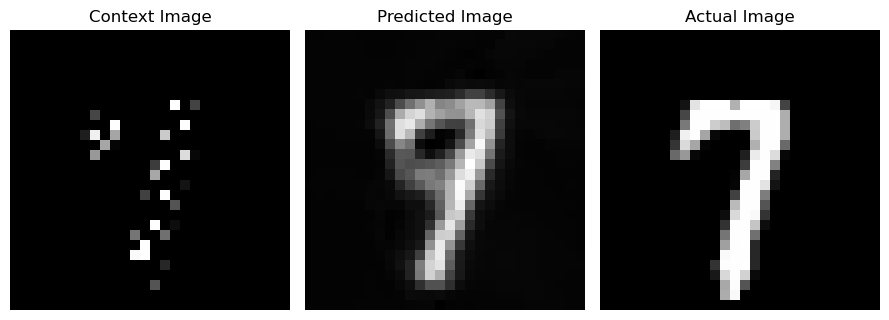

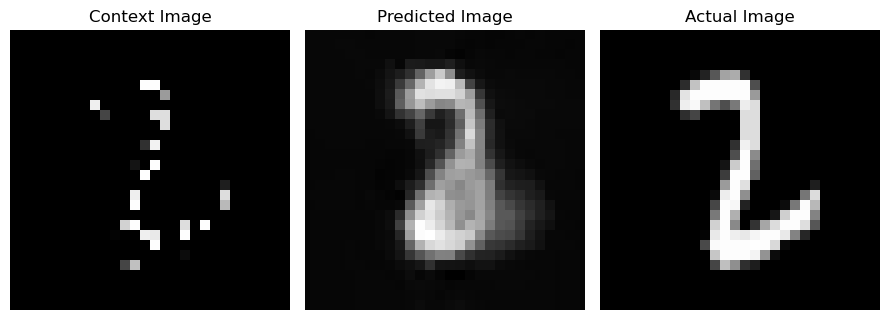

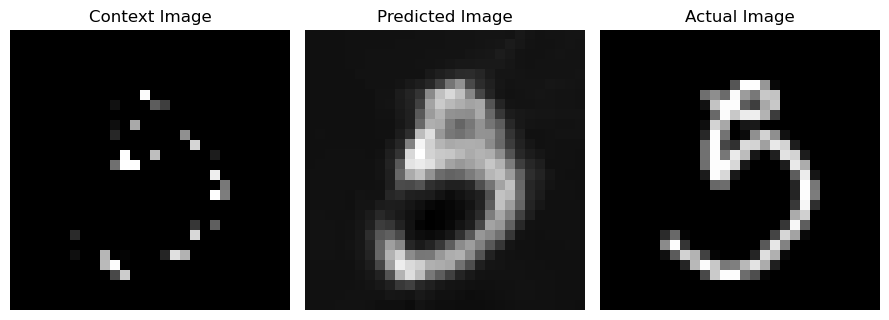

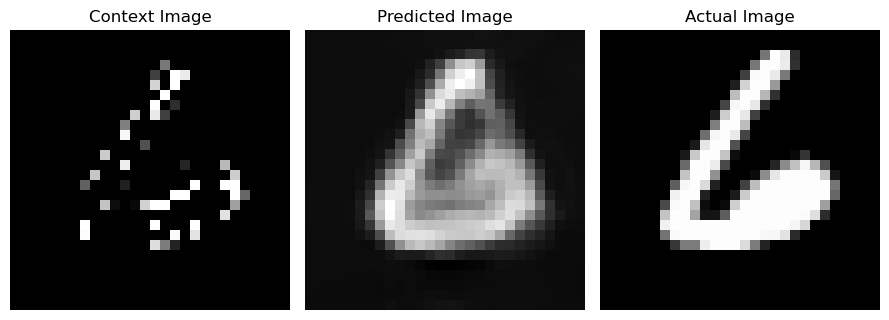

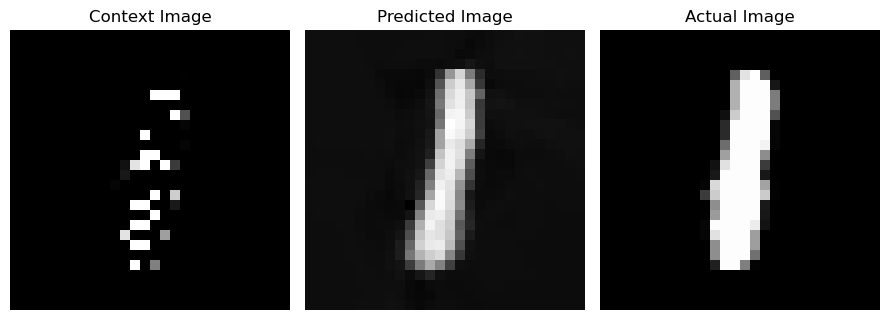

In [353]:
for context_pairs, target_pairs in test_dataloader:
    context_pairs = context_pairs.to('cuda')
    target_pairs = target_pairs.to('cuda')

    predicted_target_pixel_intensity = model(context_pairs, target_pairs)

    for i in range(5):
        predicted_pixel = predicted_target_pixel_intensity[i].detach().cpu().numpy()
        predicted_image = predicted_pixel.reshape(28,28)

        actual_pixel = target_pairs[i][:,2].detach().cpu().numpy()
        actual_image = actual_pixel.reshape(28,28)

        context_image = np.zeros((28,28))
        context_pixel_locations = context_pairs[i][:,:2].detach().cpu().numpy().astype(int) 
        context_image[context_pixel_locations[:,0], context_pixel_locations[:,1]] = context_pairs[i][:,2].detach().cpu().numpy()

        plt.figure(figsize=(9,4))

        plt.subplot(1,3,1)
        plt.imshow(context_image, cmap='gray')
        plt.axis('off')
        plt.title('Context Image')
        
        plt.subplot(1,3,2)
        plt.imshow(predicted_image, cmap='gray')
        plt.axis('off')
        plt.title('Predicted Image')

        plt.subplot(1,3,3)
        plt.imshow(actual_image, cmap='gray')
        plt.axis('off')
        plt.title('Actual Image')
        
        plt.tight_layout()
        plt.show()

    break
